# Logistic Regreesion Demo 

## Summary

In this note, I will process provided data and build machine learning models. The problem is a binary classification $-$ positive case is that two devices are truely related. I will implement several classifiers: (1) linear model $-$ logistic models with $L_1$ and $L_2$ regularization, and (2) two non-linear models: decision tree and random forest. Among the models, random forest gives the best performance, but the difference is not significant.

Before training models, I checked the target value $-$ `classification`, showing data is slightly imbalanced. Therefore, for classification problems we consider not only accuracy but also ROC curve to compute AUC for model performance comparison. I also reprocess the data in the following ways: (1) There exist a lot of `Nan` in `device2_bool1` feature, we need to replace these `Nan` with 0. (2) I also simply use `device1_loc1 == device2_loc1` as a boolean feature and (3) time difference between `device1_date1` and  `device2_date1`/`device2_date2` as time features.

For each algorithm, I train the models using training datasets. During training process, I implement 10-fold cross-validation to grid search optimal hyperparameters to select best models, and compare the model performance using accuracy and AUC, by test datasets. The training/test dataset is $70\%$/$30\%$ of the entire data. The best accuracy obtained is $84\%$.

There are many ways to perform feature selection. We can use subset or forward/backward stepwise selection: gradually add/remove features to find out which feature has more/less impact to explain model variance. But the ensemble classifier, random forest, is helpful enough to simply select important features. By logisitc model andrandom forest, the top-2 important features are `session_overlaps` and `bool`. 

The following is content of the note:

      A. Reading Data Using Pandas
      B. Reprocess DataFrame
          B.1 'Device2_bool1' feature
          B.2 Is 'Device1_loc1' == 'Device2_loc1' feature
          B.3 Timestamp interval feature
      C. Building ML Models
          C.1 Split training/test datasets
          C.2 L2 logistic regression model
          C.3 L1 logistic regression model
          C.4 Decision tree
          C.5 Random Forest
      D. ROC Curve and Model Comparison     
      

In [184]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn import grid_search
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.lines as mlines

## A. Reading Data Using Pandas

In [194]:
data = pd.read_csv('assessment_data.csv')
data.shape

(165474, 22)

In [135]:
data.head()

,Unnamed: 0,device1,device1_numsessions,device2,session_overlaps,device2_numsessions,device2_count2,device2_count3,device2_loc1,device2_count4,...,device2_date2,device2_bool1,additional_feature1,additional_feature2,additional_feature3,additional_feature4,additional_feature5,device1_date1,device1_loc1,classification
0,12,device1424,10,device277201,3,10,2,10,Store_2456,5,...,2017-04-01 17:53:35.0,1.0,3,2029,1.137013,1.0,0.348135,2016-11-26,Store_2456,0
1,85,device9313,8,device158640,3,11,1,11,Store_2038,11,...,2017-01-24 13:59:02.0,NaN,2,2611,1.008809,1.0,0.093441,2016-11-16,Store_2038,0
2,107,device12934,4,device219316,3,6,2,6,Store_1947,6,...,2017-07-15 13:43:06.0,1.0,2,1903,1.016816,1.0,0.128580,2016-12-30,Store_1947,0
3,108,device12989,8,device283349,2,3,1,3,Store_1900,3,...,2017-03-30 12:16:00.0,NaN,2,1973,1.011151,1.0,0.105006,2016-11-21,Store_1900,0
4,116,device14262,9,device157131,2,3,1,3,Store_2022,3,...,2016-12-04 13:46:36.0,NaN,2,2949,1.005765,1.0,0.075706,2016-11-20,Store_2022,0


In [5]:
sorted(data.columns)

['Unnamed: 0',
 'additional_feature1',
 'additional_feature2',
 'additional_feature3',
 'additional_feature4',
 'additional_feature5',
 'classification',
 'device1',
 'device1_date1',
 'device1_loc1',
 'device1_numsessions',
 'device2',
 'device2_bool1',
 'device2_count2',
 'device2_count3',
 'device2_count4',
 'device2_count5',
 'device2_date1',
 'device2_date2',
 'device2_loc1',
 'device2_numsessions',
 'session_overlaps']

In [10]:
labels = {}
for label in data['classification'].tolist():
    labels[label] = labels.get(label, 0) + 1
    
print (labels)

{0: 103008, 1: 62466}


## B. Reprocess DataFrame 

In [138]:
df = data[['classification',
 'device2_count2',
 'device2_count3',
 'device2_count4',
 'device2_count5',
 'additional_feature1',
 'additional_feature2',
 'additional_feature3',
 'additional_feature4',
 'additional_feature5',
 'device1_numsessions',
 'device2_numsessions',
 'session_overlaps']].dropna()

df.shape

(165474, 13)

In [105]:
classification = data['classification'].tolist()

### B.1 'Device2_bool1' feature

This feature may be useful. I found as `device2_bool1=Nan`, $22\%$ of observations are truely related. But if `device2_bool1=1`, $65\%$ of observations are truely related! Thus this feature should play a good role for classification and is worthy to reprocess and use later.

In [139]:
device2_bool1 = data['device2_bool1'].replace(float('Nan'),0).tolist()
labels = {}
for boolean, label in zip(device2_bool1, classification):
    labels[(boolean, label)] = labels.get((boolean, label), 0) + 1
    
print ('num of (bool1=Nan):', labels[(0.0, 1)]+labels[(0.0, 0)], ', pos rate (as bool1 is Nan) = %.3f' %round(float(labels[(0.0, 1)]/(labels[(0.0, 1)]+labels[(0.0, 0)])),3)) 
print ('num of (bool1=1):', labels[(1.0, 1)]+labels[(1.0, 0)], ', pos rate (as bool1 =1) = %.3f' %round(float(labels[(1.0, 1)]/(labels[(1.0, 1)]+labels[(1.0, 0)])),3))

num of (bool1=Nan): 106383 , pos rate (as bool1 is Nan) = 0.224
num of (bool1=1): 59091 , pos rate (as bool1 =1) = 0.654


In [140]:
df['bool'] = device2_bool1

### B.2 Is 'Device1_loc1' == 'Device2_loc1' feature

Similar, if `Device1_loc1 == Device2_loc1`, $29\%$ is positive, whereas $39\%$ for `Device1_loc1 != Device2_loc1`. Thus, this attribute should be helpful for model feature.

In [127]:
device1_loc1 = data['device1_loc1'].tolist()
device2_loc1 = data['device2_loc1'].tolist()

i, is_loc_diff = 0, {}
for x, y in zip(device1_loc1, device2_loc1):
    if x != y:
        diff = 1
    else:
        diff = 0    
    is_loc_diff[(diff, classification[i])] = is_loc_diff.get((diff, classification[i]), 0) + 1
    i += 1
    
print (is_loc_diff)
print ('num of diff loc:', is_loc_diff[(1, 1)]+is_loc_diff[(1, 0)], ', pos rate (diff loc) = %.3f' %round(float(is_loc_diff[(1, 1)]/(is_loc_diff[(1, 1)]+is_loc_diff[(1, 0)])),3)) 
print ('num of same loc:', is_loc_diff[(0, 1)]+is_loc_diff[(0, 0)], ', pos rate (same loc) = %.3f' %round(float(is_loc_diff[(0, 1)]/(is_loc_diff[(0, 1)]+is_loc_diff[(0, 0)])),3))

{(0, 1): 57333, (1, 0): 12840, (0, 0): 90168, (1, 1): 5133}
num of diff loc: 17973 , pos rate (diff loc) = 0.286
num of same loc: 147501 , pos rate (same loc) = 0.389


In [141]:
is_loc_diff = []
for x, y in zip(data['device2_loc1'].tolist(), data['device1_loc1'].tolist()):
    if x != y:
        is_loc_diff.append(1)
    else:
        is_loc_diff.append(0)
        
df['is_loc_diff'] = is_loc_diff

### B.3 Timestamp interval feature

Direcly using the timestamp from data is not useful. Here I just simply consider the day difference between `device1_date1` and `device2_date1`/`device2_date2` as two model features.

In [142]:
time_diff_1, time_diff_2 = [], []
for i, row in enumerate(data.iterrows()):
    row = row[1]
    device1_date1 = row['device1_date1']
    device2_date1 = row['device2_date1']
    device2_date2 = row['device2_date2']
    time_diff_1.append((datetime.strptime(device1_date1, '%Y-%m-%d')-datetime.strptime(device2_date1.split(' ')[0], '%Y-%m-%d')).days)
    time_diff_2.append((datetime.strptime(device1_date1, '%Y-%m-%d')-datetime.strptime(device2_date2.split(' ')[0], '%Y-%m-%d')).days)
    
df['time_diff_1'] = time_diff_1
df['time_diff_2'] = time_diff_2

In [143]:
df.head()

,classification,device2_count2,device2_count3,device2_count4,device2_count5,additional_feature1,additional_feature2,additional_feature3,additional_feature4,additional_feature5,device1_numsessions,device2_numsessions,session_overlaps,bool,is_loc_diff,time_diff_1,time_diff_2
0,0,2,10,5,5,3,2029,1.137013,1.0,0.348135,10,10,3,1.0,0,30,-126
1,0,1,11,11,11,2,2611,1.008809,1.0,0.093441,8,11,3,0.0,0,49,-69
2,0,2,6,6,6,2,1903,1.016816,1.0,0.128580,4,6,3,1.0,0,35,-197
3,0,1,3,3,3,2,1973,1.011151,1.0,0.105006,8,3,2,0.0,0,-57,-129
4,0,1,3,3,3,2,2949,1.005765,1.0,0.075706,9,3,2,0.0,0,30,-14


In [145]:
df.shape

(165474, 17)

In [148]:
df.columns

Index(['classification', 'device2_count2', 'device2_count3', 'device2_count4',
       'device2_count5', 'additional_feature1', 'additional_feature2',
       'additional_feature3', 'additional_feature4', 'additional_feature5',
       'device1_numsessions', 'device2_numsessions', 'session_overlaps',
       'bool', 'is_loc_diff', 'time_diff_1', 'time_diff_2'],
      dtype='object')

Now there are 17 features in data.

## C. Building ML Model

I will implement two linear models: logistic models with $L_1$ and $L_2$ regularization and two non-linear models: Decision tree and random forest. For each, I do 10-fold cross validation for grid search optimal model hyper-parameters.

### C.1 Split training/test datasets

Take $70%$ as training dataset and $30\%$ as test dataset.

In [151]:
X = df[['device2_count2', 'device2_count3', 'device2_count4', 'device2_count5', 
   'additional_feature1', 'additional_feature2','additional_feature3', 'additional_feature4', 'additional_feature5',
    'device1_numsessions', 'device2_numsessions', 'session_overlaps',
    'bool', 'is_loc_diff', 'time_diff_1', 'time_diff_2']]
 
Y = df['classification']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3);
print (X_train.shape, y_train.shape, X_test.shape)

(115831, 16) (115831,) (49643, 16)


### C.2 L2 logistic regression model

First try linear model $-$ logistic regression with $L_2$ regularization. 

In [159]:
best_logreg_model = None
max_score = -1
best_reg = -1
for regularization_param in [x*0.01 for x in range(1, 10)]:
    logreg = linear_model.LogisticRegression('l2', C=regularization_param)
    cv_score = cross_val_score(logreg, X_train, y_train, cv=10)
    print (regularization_param, np.mean(cv_score))
    if np.mean(cv_score) > max_score:
        max_score = np.mean(cv_score)
        best_logreg_model = logreg
        best_reg = regularization_param

best_logreg_model.fit(X_train, y_train)
print ('best reg parameter = %.3f' %best_reg, ', accuracy = %.3f' %best_logreg_model.score(X_test, y_test))

0.01 0.818373414846
0.02 0.817691381571
0.03 0.817915804489
0.04 0.818218015435
0.05 0.818390654696
0.06 0.81810576708
0.07 0.817510120147
0.08 0.817371917357
0.09 0.81753598216
best reg parameter = 0.050 , accuracy = 0.817


In [175]:
logreg_y_test_prob = best_logreg_model.predict_proba(X_test)

### C.3 L1 logistic regression model

Logistic regression with  $L_1$  regularization.

In [174]:
best_L1_model = None
max_score = -1
best_reg = -1
for regularization_param in [0.01, 0.1, 0.5, 1, 2, 5, 10, 50, 100]:
    logreg = linear_model.LogisticRegression('l1', C=regularization_param)
    cv_score = cross_val_score(logreg, X_train, y_train, cv=10)
    print (regularization_param, np.mean(cv_score))
    if np.mean(cv_score) > max_score:
        max_score = np.mean(cv_score)
        best_L1_model = logreg
        best_reg = regularization_param

best_L1_model.fit(X_train, y_train)
print ('best reg parameter = %.3f' %best_reg, ', accuracy = %.3f' %best_L1_model.score(X_test, y_test))

0.01 0.817941758924
0.1 0.817708670614
0.5 0.817665499432
1 0.817613690436
2 0.817674124575
5 0.817674130538
10 0.817777728406
50 0.817674123085
100 0.817708664651
best reg parameter = 0.010 , accuracy = 0.818


In [212]:
df = pd.DataFrame({'feature': list(X.columns), 'weight': list(best_L1_model.coef_[0])})
df.head(16)

,feature,weight
0,device2_count2,-0.358020
1,device2_count3,-0.017122
2,device2_count4,-0.045442
3,device2_count5,-0.000518
4,additional_feature1,-0.508544
5,additional_feature2,-0.000088
6,additional_feature3,-0.810275
7,additional_feature4,-0.104529
8,additional_feature5,-0.776871
9,device1_numsessions,-0.099178


Compare to feature list, the largest weight is `bool` and second is `session_overlaps`. Interestingly, `is_loc_diff`  contributes to zero importance.

In [176]:
L1_y_test_prob = best_logreg_model.predict_proba(X_test)

### C.4 Decision tree

Then non-linear model: decision tree. 

In [164]:
best_tree_model = None
best_nfeatures = -1
best_depth = -1
max_score = -1
for features in [4, 6, 8, 10, 12, 14, 16]:
    for depth in [5, 10, 15, 20]:
        tree = DecisionTreeClassifier(max_features = features, max_depth = depth, random_state=0)
        cv_score = cross_val_score(tree, X_train, y_train, cv=10)  
        acc = np.mean(cv_score) 
        print (features, depth, acc)
        if acc > max_score:
            best_nfeatures = features 
            best_depth = depth
            best_tree_model = tree
            max_score = acc

best_tree_model.fit(X_train, y_train)
print ('best tree parameter =', (best_nfeatures, best_depth), ', accuracy = %.3f' %best_logreg_model.score(X_test, y_test))

4 5 0.764941954718
4 10 0.816404682674
4 15 0.810689691994
4 20 0.782571055034
6 5 0.776778332972
6 10 0.829544754454
6 15 0.81112998722
6 20 0.784435863626
8 5 0.785722249468
8 10 0.829432488962
8 15 0.812200565606
8 20 0.7853337215
10 5 0.796168652206
10 10 0.832281549218
10 15 0.811725687074
10 20 0.786533808965
12 5 0.80102047489
12 10 0.831910232778
12 15 0.812053760777
12 20 0.785955349702
14 5 0.801046367463
14 10 0.834034086344
14 15 0.81192424947
14 20 0.78716400268
16 5 0.805095434686
16 10 0.835018240379
16 15 0.813305657236
16 20 0.785843080479
best tree parameter = (16, 10) , accuracy = 0.817


The optimal number of features is 16, and optimal depth is 10. Decision tree doesn't have obviously outperform linear models.

In [172]:
tree_y_test_prob = best_tree_model.predict_proba(X_test)

### C.5 Random Forest

In [166]:
rf = RandomForestClassifier()
parameters = {'n_estimators': [4,6,8,10,12,14,16],'max_depth':[5,10,15],'min_samples_leaf':[5,10,20]}
model_cv_grid = grid_search.GridSearchCV(rf,parameters,scoring='roc_auc',verbose=0, n_jobs=-1)
model_cv_grid.fit(X_train,y_train)
best_rf_model = model_cv_grid.best_estimator_;

In [167]:
best_rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=14, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [168]:
print ('accuracy = %.3f' %best_rf_model.score(X_test, y_test))

accuracy = 0.843


Random forest shows significant improvement, about 2% accuracy increase. next we can check which features are important:

In [214]:
importance = best_rf_model.feature_importances_
attribute = X.columns

v = sorted(range(len(importance)), key=lambda k: importance[k], reverse=True)
sorted_importance = [importance[i] for i in v]
sorted_attribute = [attribute[i] for i in v]

df_importance = pd.DataFrame({'variable': sorted_attribute, 'importance' : sorted_importance})
df_importance.sort_index().head(16)

,importance,variable
0,0.257493,session_overlaps
1,0.240956,bool
2,0.078015,device1_numsessions
3,0.070681,device2_count2
4,0.069220,additional_feature3
5,0.065720,additional_feature5
6,0.047779,additional_feature1
7,0.041120,additional_feature2
8,0.033980,device2_numsessions
9,0.021088,device2_count3


The top-3 important features are (1) `session_overlaps` (2) `bool` (3) `device1_numsessions`. But difference between No.3 and No. 4 is not obvious, so the rank below No. 3 is not significant. However, the observation of first two important features  `session_overlaps` and `bool` is consistent with using logistic models with $L_1$ regularizaiton. Moreover, `is_loc_diff` still shows small contribution in random forest models.

In [170]:
rf_y_test_prob = best_rf_model.predict_proba(X_test)

## D. ROC Curve and Model Comparison

In the following, we plot the ROC curves for each model and compute AUC. The random forest still shows the largest area and outperforms others. However, the difference between the models is not significant.

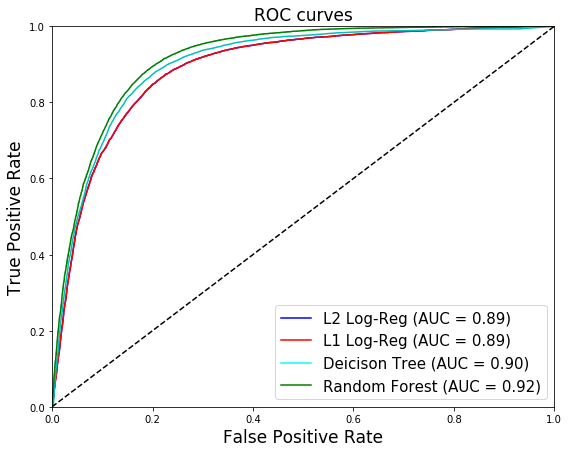

In [195]:
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_test, logreg_y_test_prob[:,1])
roc_auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)

fpr_L1, tpr_L1, _ = metrics.roc_curve(y_test, L1_y_test_prob[:,1])
roc_auc_L1 = metrics.auc(fpr_L1, tpr_L1)

fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test, tree_y_test_prob[:,1])
roc_auc_tree = metrics.auc(fpr_tree, tpr_tree)

fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, rf_y_test_prob[:,1])
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)

plt.figure(figsize=(9,7))
plt.plot(fpr_logreg, tpr_logreg, color = 'b')
plt.plot(fpr_L1, tpr_L1, color = 'r')   #m: magenta
plt.plot(fpr_tree, tpr_tree, color = 'c')
plt.plot(fpr_rf, tpr_rf, color = 'g')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=17)
plt.ylabel('True Positive Rate', fontsize=17)
plt.title('ROC curves', fontsize=17)

blue_line = mlines.Line2D([], [], color='blue', label='L2 Log-Reg (AUC = %0.2f)' % roc_auc_logreg)
red_line = mlines.Line2D([], [], color='red', label='L1 Log-Reg (AUC = %0.2f)' % roc_auc_L1)
yellow_line = mlines.Line2D([], [], color='cyan', label='Deicison Tree (AUC = %0.2f)' % roc_auc_tree)
green_line = mlines.Line2D([], [], color='green', label='Random Forest (AUC = %0.2f)' % np.mean(roc_auc_rf))

plt.legend(handles=[blue_line, red_line, yellow_line, green_line],loc="lower right", fontsize=15)
plt.show()